<div>
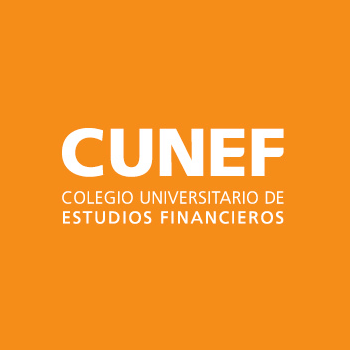
</div>


# **Desempleo en España (intervenido)**

En este notebook se mostrará la serie temporal de la **tasa de paro INTERVENIDO en España** y observaremos cómo afectaría este conjunto de datos si suprimiéramos el momento COVID-19.


Estructura del notebook:
    
    1) Librerías utilizadas
    2) Lectura, preprocesado e intervención del momento COVID-19
    3) EDA (Análisis Exploratorio de Datos)
    4) Elección del modelo predictivo
        4.1) Modelo de suavizado exponencial (ETS)
        4.2) Modelo autorregresivo integrado de media móvil (ARIMA)
        4.3) Modelo FB Prophet
        4.4) Comparativa errores y elección del mejor modelo
    5) Predicción hasta finales de año 

## *1) Librerías utilizadas*

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
from prophet import Prophet
from sktime.forecasting.arima import AutoARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics import tsaplots
from sktime.utils.plotting import plot_correlations
from statsmodels.tsa.seasonal import seasonal_decompose
from sktime.transformations.series.boxcox import LogTransformer
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
from sktime.performance_metrics.forecasting import MeanSquaredError
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.transformations.series.difference import Differencer
from sktime.utils.plotting import plot_series
from sktime.forecasting.ets import AutoETS
warnings.filterwarnings('ignore')

## *2) Lectura, preprocesado e intervención*

- Fuente: https://www.sepe.es/HomeSepe/que-es-el-sepe/estadisticas/datos-avance/paro.html

In [14]:
df_paro=pd.read_excel("evolparoseries2.xls",index_col=0)
df_paro.tail()

,mes,total,agricultura,industria,construccion,servicios,sin_empleo_ant
NaN,202203,3108763,156354,254532,249107,2192580,256190
NaN,202204,3022503,146810,250192,242135,2127158,256208
NaN,202205,2922991,138117,242224,232127,2062928,247595
NaN,202206,2880582,146980,235076,227146,2021911,249469
NaN,202207,2883812,147805,233167,228122,2033148,241570


In [15]:
df_paro.mes=pd.to_datetime(df_paro.mes,format='%Y%m')

df_paro=df_paro.set_index("mes")
df_paro=df_paro.iloc[:,0:1]
df_paro

,total
mes,
2013-01-01,4980778
2013-02-01,5040222
2013-03-01,5035243
2013-04-01,4989193
2013-05-01,4890928
...,...
2022-03-01,3108763
2022-04-01,3022503
2022-05-01,2922991


Vamos a representar gráficamente el conjunto de datos resaltando todo el momento COVID-19 y vamos a ver qué meses son los que más han alterado la predicción:

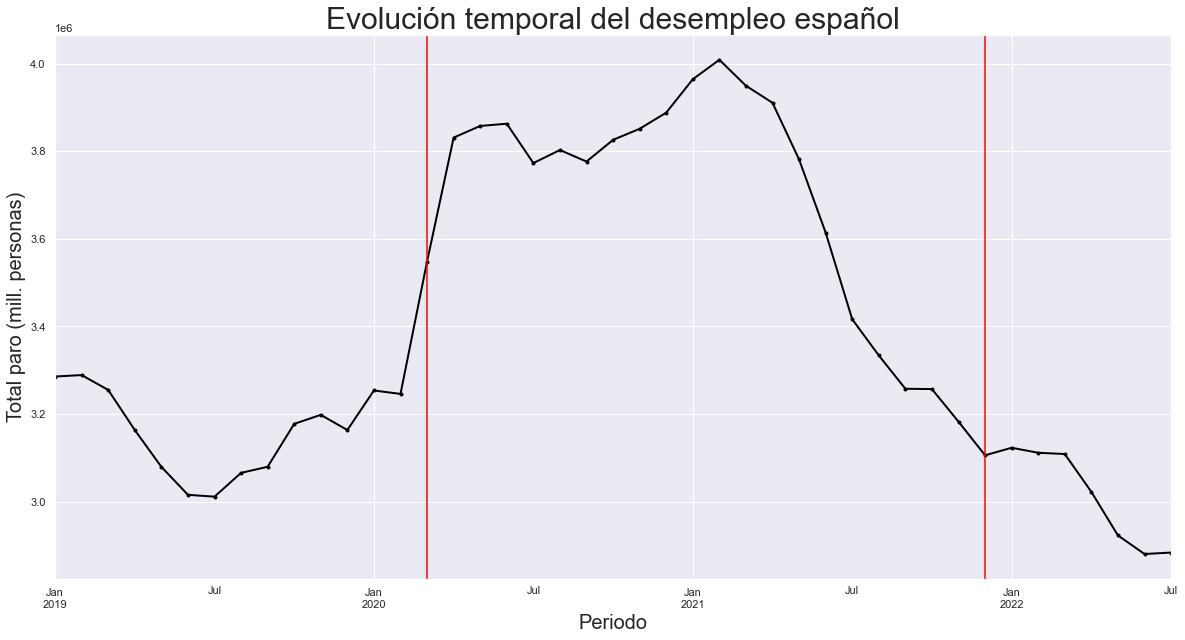

In [16]:
sns.set(rc={'figure.figsize':(20,10)})
fig=df_paro.total['2019':].plot(marker='.',color ='black',linewidth= 2)
fig.set_title('Evolución temporal del desempleo español',fontsize=30)
fig.set_ylabel('Total paro (mill. personas)',fontsize=20)
fig.axvline('2020-03-01',color='red',linewidth=1.5)
fig.axvline('2021-12-01', color='red', linewidth=1.5)
fig.set_xlabel('Periodo',fontsize=20);
# fig.figure.savefig('../pics/df_paro_new/beforemanipulation')

Vemos que desde marzo del 2020 hasta diciembre del 2021 son los meses que más datos de desempleo hay por el efecto COVID-19, esto son **21 meses** (incluyendo ambos meses). Vamos a quedarnos con los datos hasta febrero del 2020, justo antes del inicio de la pandemia en nuestro país, y vamos a hacer un entrenamiento-test con autoETS para rellenar los datos hasta diciembre 2021 inclusive. 

**¿Por qué con AutoETS?** Porque se ha comprobado en el análisis anterior que era más preciso que el autoARIMA.

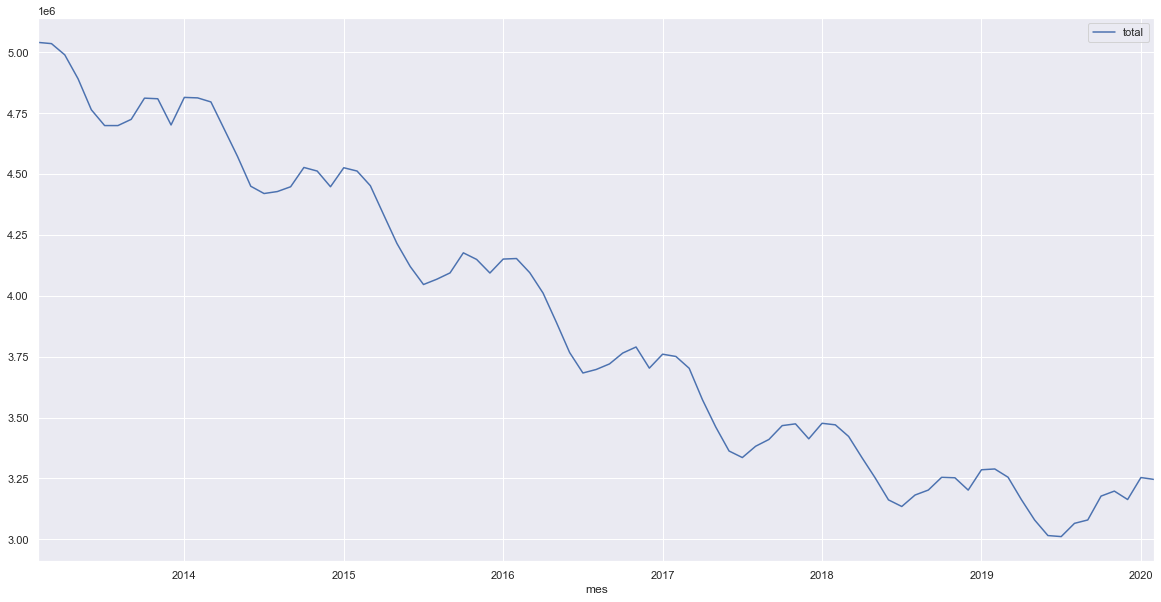

In [17]:
# Nos quedamos de momento con los datos hasta febrero de 2021:
df_paro2 = df_paro.loc['2013-02':'2020-02']
# Hacemos la predicción sobre esta time series:
df_paro2.plot();

Cantidad de períodos en Train: 64
Cantidad de períodos en Test: 21


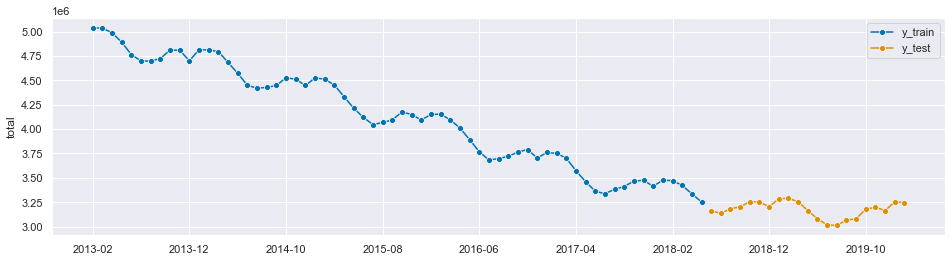

In [18]:
#y_train, y_test
y_train, y_test = temporal_train_test_split(
    y=df_paro2['total'].astype('float64').to_period('M'),test_size = 21) # 17 meses (mar2020 - dic2021)
plot_series(y_train, y_test, labels=["y_train","y_test"])
print('Cantidad de períodos en Train:', y_train.shape[0])
print('Cantidad de períodos en Test:', y_test.shape[0])
plt.show()

In [19]:
y_test

2018-06    3162162.0
2018-07    3135021.0
2018-08    3182068.0
2018-09    3202509.0
2018-10    3254703.0
2018-11    3252867.0
2018-12    3202297.0
2019-01    3285761.0
2019-02    3289040.0
2019-03    3255084.0
2019-04    3163566.0
2019-05    3079491.0
2019-06    3015686.0
2019-07    3011433.0
2019-08    3065804.0
2019-09    3079711.0
2019-10    3177659.0
2019-11    3198184.0
2019-12    3163605.0
2020-01    3253853.0
2020-02    3246047.0
Freq: M, Name: total, dtype: float64

Aplicamos el modelo AutoETS para que testee el modelo entrenado.

In [20]:
fh = np.arange(1, y_test.shape[0]+1)
paro_auto_ets=AutoETS(auto=True,sp=12,n_jobs=1)

In [21]:
paro_auto_ets.fit(y_train)

AutoETS(auto=True, n_jobs=1, sp=12)

In [22]:
paro_pred = paro_auto_ets.predict(fh)
paro_pred.round()

2018-06    3160929.0
2018-07    3114703.0
2018-08    3127336.0
2018-09    3143428.0
2018-10    3193634.0
2018-11    3189420.0
2018-12    3128296.0
2019-01    3181014.0
2019-02    3172968.0
2019-03    3137772.0
2019-04    3060523.0
2019-05    2976176.0
2019-06    2890804.0
2019-07    2846620.0
2019-08    2856220.0
2019-09    2868934.0
2019-10    2912713.0
2019-11    2906797.0
2019-12    2849028.0
2020-01    2894911.0
2020-02    2885433.0
Freq: M, dtype: float64

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='total'>)

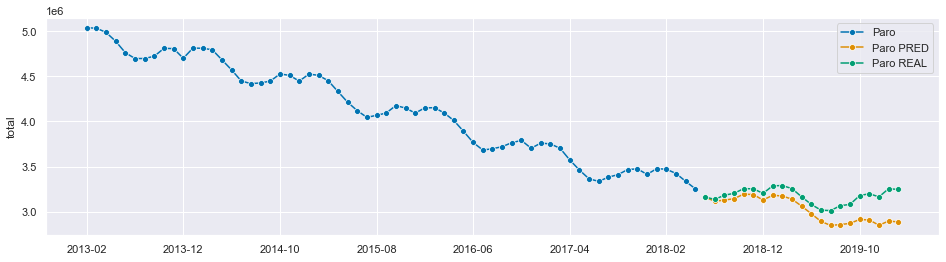

In [23]:
plot_series(y_train, paro_pred, y_test,labels= ["Paro", 'Paro PRED', 'Paro REAL'],)

El modelo se comporta bien y da una precisión buena, por lo que aplicaremos un horizonte nuevo de predicción y los datos que nos prediga hasta diciembre del 2021 serán los datos con los que vayamos a trabajar para testear los modelos y hacer una posterior predicción hasta finales del 2022.

In [24]:
paro_ficticio = df_paro.loc['2016-02': '2020-02']
fh=np.arange(1, 23) # hasta diciembre 2021
df_auto = AutoETS(auto= True, 
                  sp =12, #mensual
                  n_jobs=1)
y = paro_ficticio.total.astype('float64').to_period('M')
df_auto.fit(y)
print(df_auto.summary())

                                 ETS Results                                  
Dep. Variable:                  total   No. Observations:                   49
Model:                       ETS(MNM)   Log Likelihood                -595.486
Date:                Wed, 31 Aug 2022   AIC                           1222.973
Time:                        13:10:09   BIC                           1253.242
Sample:                    02-29-2016   HQIC                          1234.457
                         - 02-29-2020   Scale                            0.000
Covariance Type:               approx                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.9999      0.171      5.863      0.000       0.666       1.334
smoothing_seasonal   2.501e-05      0.254   9.85e-05      1.000      -0.498       0.498
initial_level   

In [27]:
#step 5: querying predictions
paro_pred = df_auto.predict(fh=list(fh))
paro_pred.round()

2020-03    3221036.0
2020-04    3149557.0
2020-05    3076371.0
2020-06    3008092.0
2020-07    2993202.0
2020-08    3046869.0
2020-09    3081875.0
2020-10    3157268.0
2020-11    3185016.0
2020-12    3147761.0
2021-01    3234131.0
2021-02    3246048.0
2021-03    3221036.0
2021-04    3149557.0
2021-05    3076371.0
2021-06    3008092.0
2021-07    2993202.0
2021-08    3046869.0
2021-09    3081875.0
2021-10    3157268.0
2021-11    3185016.0
2021-12    3147761.0
Freq: M, dtype: float64

Ya tenemos los datos predichos hasta diciembre-2021, vamos a suprimir los datos del desempleo alterados por la etapa COVID-19 y vamos a usar los datos predecidos por este modelo.

In [28]:
df_paro_new = df_paro
df_paro_new.loc['2020-03-01':'2021-12-01','total'] = ['3221036','3149557','3076371','3008092','2993202',
                                                      '3046869','3081875','3157268','3185016','3147761',
                                                      '3234131','3246048','3221036','3149557','3076371',
                                                      '3008092','2993202','3046869','3081875','3157268',
                                                      '3185016','3147761']

In [31]:
df_paro_new

,total
mes,
2013-01-01,4980778
2013-02-01,5040222
2013-03-01,5035243
2013-04-01,4989193
2013-05-01,4890928
...,...
2022-03-01,3108763
2022-04-01,3022503
2022-05-01,2922991


In [32]:
# hay que pasar los datos de tipo objeto a tipo numérico (float)
df_paro_new = pd.to_numeric(df_paro_new.total)
df_paro_new.dtypes

dtype('int64')

Text(0.5, 0, 'Periodo')

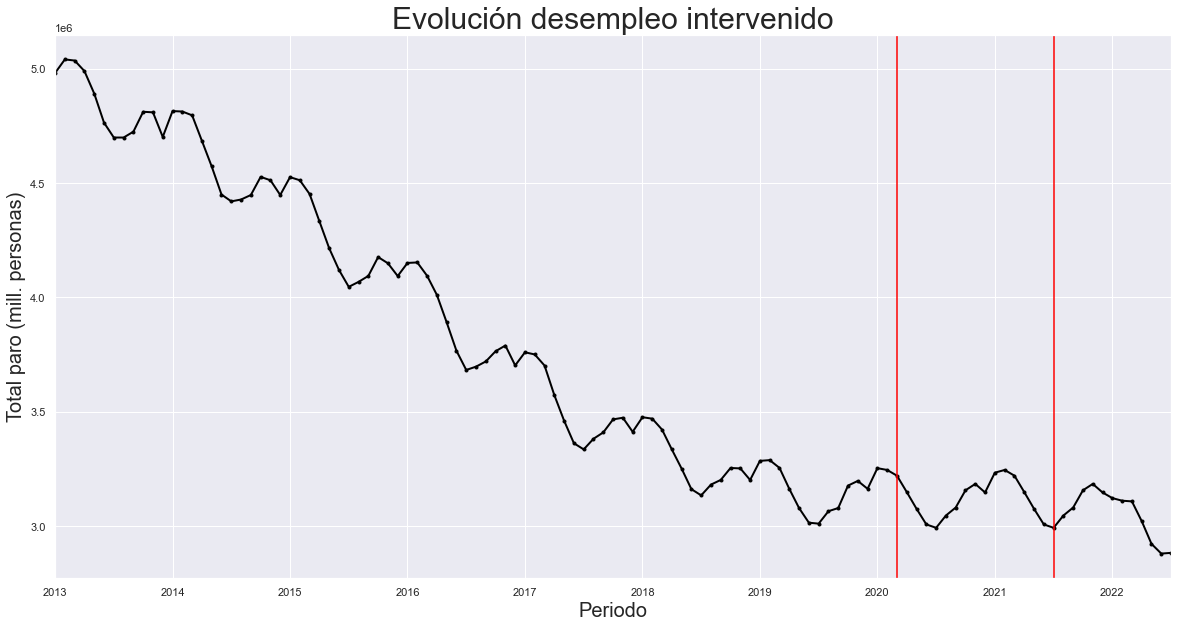

In [33]:
sns.set(rc={'figure.figsize':(20,10)})
fig=df_paro_new.plot(marker='.',color ='black',linewidth= 2)
fig.set_title('Evolución desempleo intervenido',fontsize=30)
fig.set_ylabel('Total paro (mill. personas)',fontsize=20)
fig.axvline('2020-03-01',color='red',linewidth=1.5)
fig.axvline('2021-07-01', color='red', linewidth=1.5)
fig.set_xlabel('Periodo',fontsize=20)
# fig.figure.savefig('../pics/df_paro_new/aftermanipulation');

Ahora sí que guarda una tendencia y una estacionalidad similar. Vamos a hacer un breve EDA (esta vez con todo el DataFrame al no haber momento atípico por COVID-19) y luego procedemos ahora a predecir la serie temporal con los modelos.

## *3) EDA*

### 3.1) Test de Dickey-Fuller aumentada

Esta prueba nos proporciona una verificación rápida y evidente de si la serie es estacionaria o no.

**La hipótesis nula (H0)** de la prueba es que la serie temporal se puede representar mediante una raíz unitaria, que no es estacionaria, es decir, que tiene alguna estructura dependiente del tiempo. 

**La hipótesis alternativa (H1)**, que rechaza la hipótesis nula, indica que la serie temporal es estacionaria.

Interpretamos este resultado utilizando el p-value. Un valor p por debajo del umbral de significancia (0.05) significa que la hipótesis nula se rechaza.

In [34]:
def test_stationarity(timeseries):
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

test_stationarity(df_paro_new)

Results of Dickey-Fuller Test:
Test Statistic                  -3.527778
p-value                          0.007302
#Lags Used                      12.000000
Number of Observations Used    102.000000
Critical Value (1%)             -3.496149
Critical Value (5%)             -2.890321
Critical Value (10%)            -2.582122
dtype: float64


**La serie temporal sigue siendo estacionaria**, debido a que el p-value del test Dickey-Fuller (0.006) es menor que 0.05, y eso indica que se rechaza la hipótesis nula (H0).

### 3.2) Comportamiento mensual

Text(0.5, 1.0, 'Comportamiento mensual')

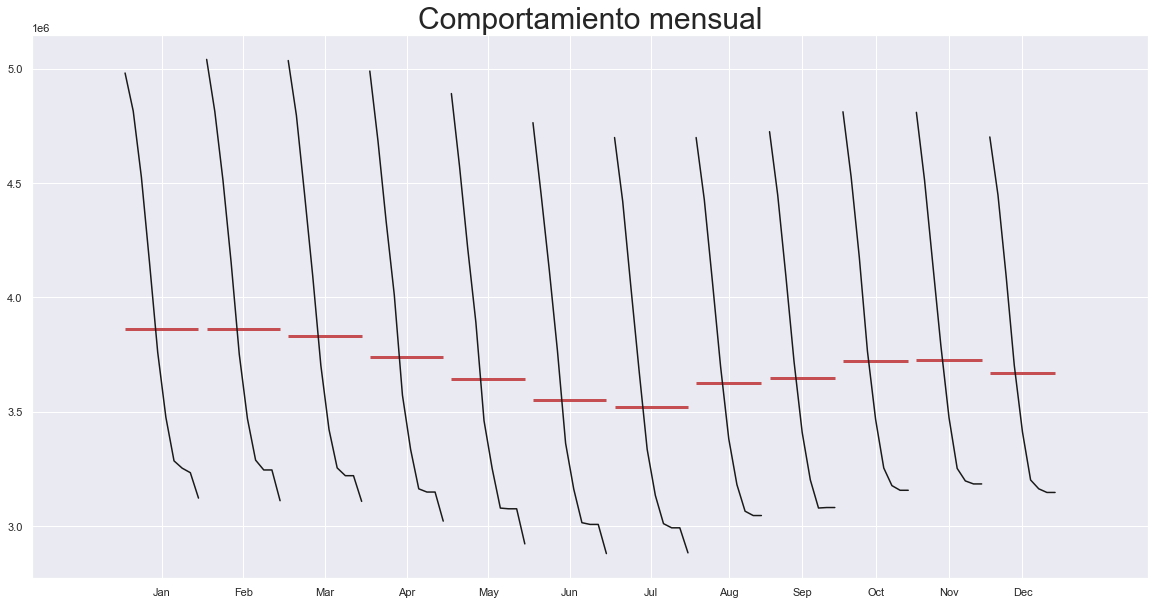

In [35]:
ax=plt.gca() 
sm.graphics.tsa.month_plot(df_paro_new,ax=ax)
ax.set_title('Comportamiento mensual',fontsize=30)
# fig.figure.savefig('../pics/df_paro_new/monthlybehavior.png');

Sigue cumpliendo con la estacionalidad del desempleo real.

### 3.3) Descomposición

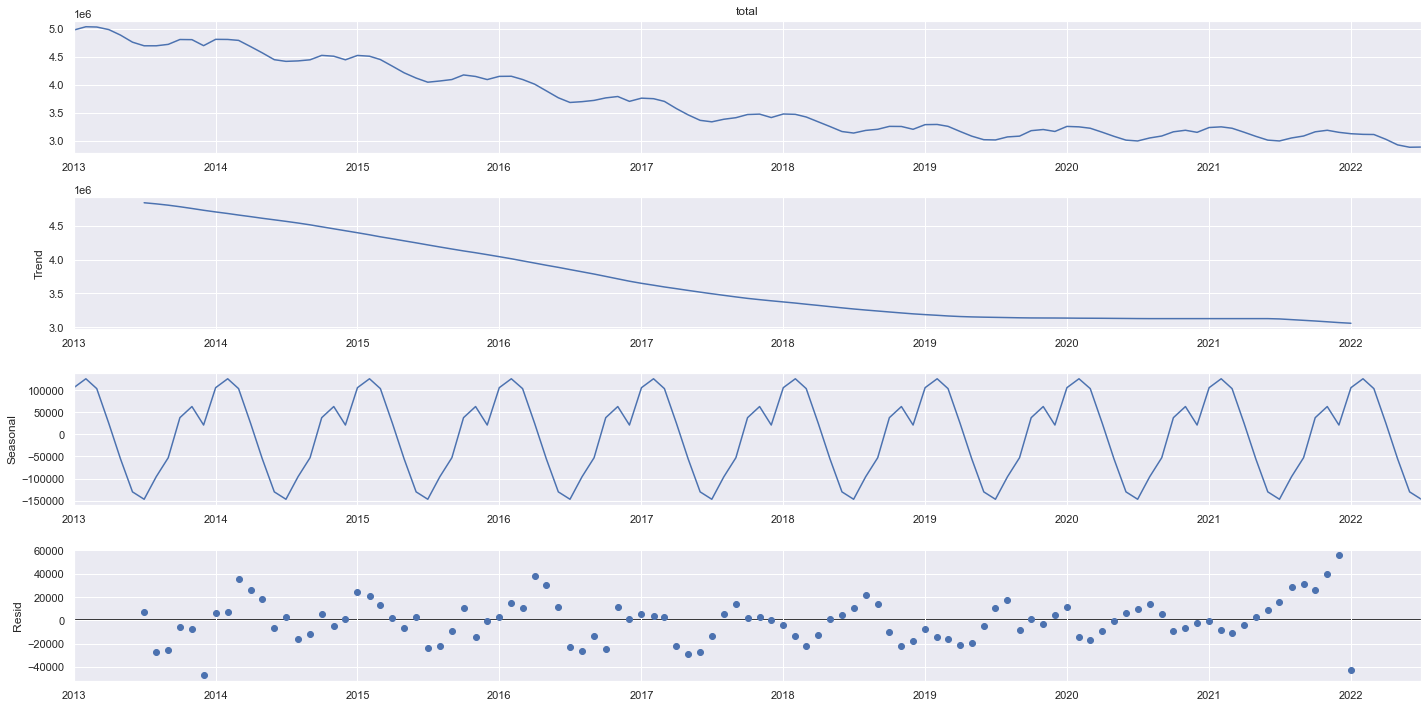

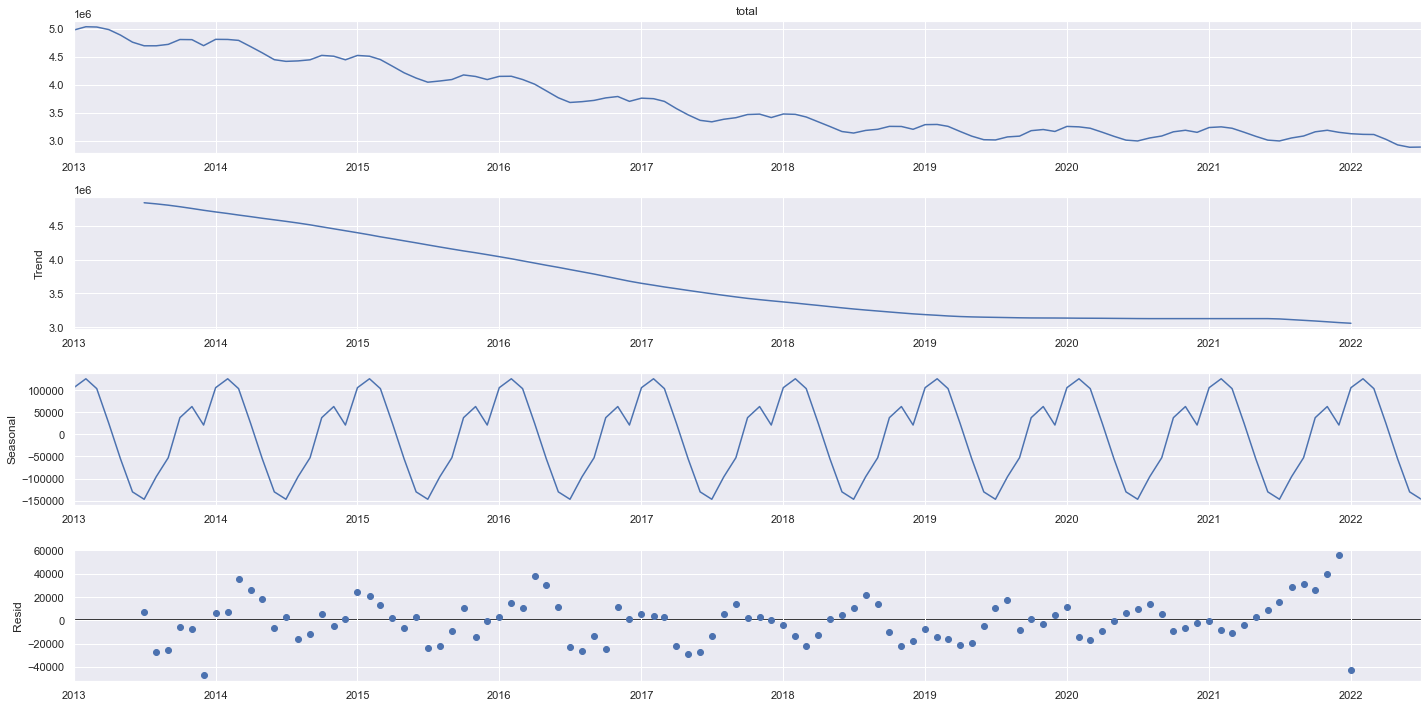

In [36]:
desglose=seasonal_decompose(df_paro_new, 
                                   model='additive', 
                                   period=12);
desglose.plot()
# plt.savefig('../pics/df_paro_new/decompose.png');

Analizando las gráficas una vez intervenida la serie, observamos:

- Que existe una **tendencia decreciente en todo momento**.
- Que la serie **sigue siendo estacionaria**.
- Hay **componente estacional**.


## *4) Estimación mediante modelos*



### 4.1) Modelo de Suavizado Exponencial (ETS)

Cantidad de períodos en Train: 86
Cantidad de períodos en Test: 29


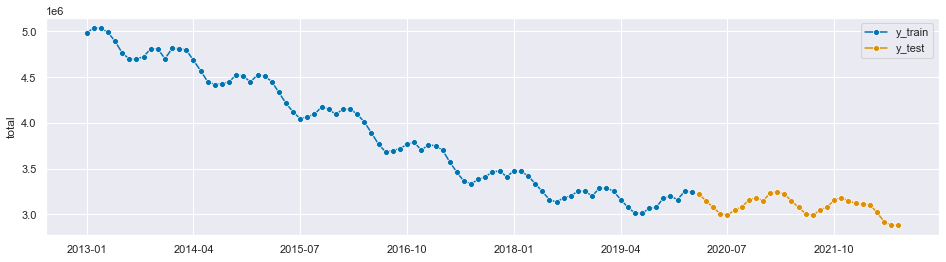

In [37]:
#Train-test
y_train,y_test_ets=temporal_train_test_split(
    y=df_paro_new.astype('float64').to_period('M').sort_index(),test_size=29
)
# Grafico para representar la separación de los datos
plot_series(y_train, y_test_ets, labels=["y_train","y_test"])
print('Cantidad de períodos en Train:', y_train.shape[0])
print('Cantidad de períodos en Test:', y_test_ets.shape[0])
plt.show()

In [38]:
y_test_ets

2020-03    3221036.0
2020-04    3149557.0
2020-05    3076371.0
2020-06    3008092.0
2020-07    2993202.0
2020-08    3046869.0
2020-09    3081875.0
2020-10    3157268.0
2020-11    3185016.0
2020-12    3147761.0
2021-01    3234131.0
2021-02    3246048.0
2021-03    3221036.0
2021-04    3149557.0
2021-05    3076371.0
2021-06    3008092.0
2021-07    2993202.0
2021-08    3046869.0
2021-09    3081875.0
2021-10    3157268.0
2021-11    3185016.0
2021-12    3147761.0
2022-01    3123078.0
2022-02    3111684.0
2022-03    3108763.0
2022-04    3022503.0
2022-05    2922991.0
2022-06    2880582.0
2022-07    2883812.0
Freq: M, Name: total, dtype: float64

In [39]:
# Especifico la cantidad de períodos a estimar para obtener las observaciones predichas en test.
fh = np.arange(1, y_test_ets.shape[0]+1)

# Selecciono el modelo y sus parámetros de predicción, al igual que los recursos a utilizar para entrenar
paronew_auto_ets = AutoETS(auto=True, sp=12, n_jobs=-1)
paronew_auto_ets.fit(y_train)

AutoETS(auto=True, n_jobs=-1, sp=12)

In [40]:
#step 5: querying predictions
paronew_pred = paronew_auto_ets.predict(fh=list(fh))
(paronew_pred.round()).tail()

2022-03    3138814.0
2022-04    3075082.0
2022-05    3005860.0
2022-06    2938286.0
2022-07    2916881.0
Freq: M, dtype: float64

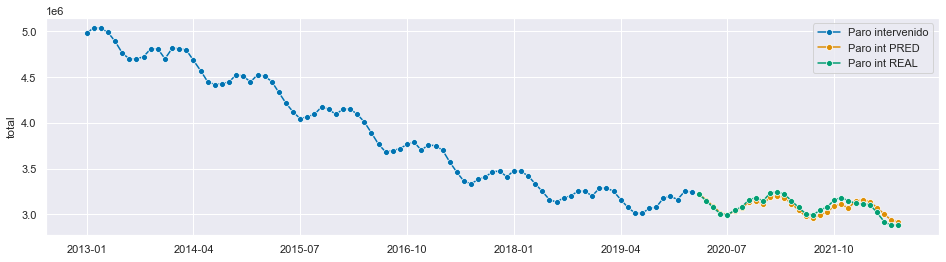

In [41]:
# optional: plotting predictions and past data
plot_series(y_train, paronew_pred, y_test_ets, labels=["Paro intervenido", "Paro int PRED", "Paro int REAL"])
plt.show()

In [42]:
mse = MeanSquaredError(square_root=True)
mse_ets = mse(y_test_ets, paronew_pred)
print('El modelo ETS genera un RMSE de:', round(mse_ets,2))

El modelo ETS genera un RMSE de: 42413.41


In [43]:
mape = MeanAbsolutePercentageError(symmetric=False)
mape_ets = mape(y_test_ets, paronew_pred)
print('El modelo ETS genera un MAPE de: {}%'.format(round(mape_ets*100,2)))

El modelo ETS genera un MAPE de: 1.19%


El modelo tiene un error muy pequeño y predice extremadamente bien. 

### 4.2) Modelo ARIMA

Al tratarse de una serie estacionaria no hay que transformar la serie obtener mejores predicciones con el método de estimación ARIMA.

Separamos el train y el test:

86 29


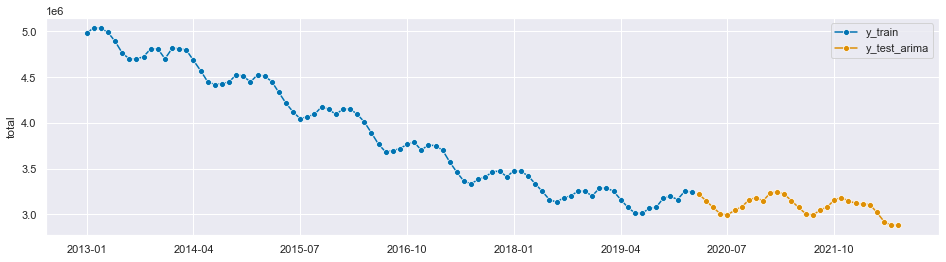

In [46]:
y_train,y_test_arima=temporal_train_test_split(
    y=df_paro_new.astype('float64').to_period('M').sort_index(),test_size=29)

plot_series(y_train, y_test_arima, labels=["y_train", "y_test_arima"])
print(y_train.shape[0], y_test_arima.shape[0])
plt.show()

Generamos el modelo y se entrena con los datos del train:

In [54]:
fh = np.arange(1, y_test_arima.shape[0]+1)
paronew_auto_arima=AutoARIMA(d=1,D=1,sp=12,suppress_warnings=True)

In [55]:
paronew_auto_arima.fit(y_train)
paronew_auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   86
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -836.149
Date:                            Wed, 31 Aug 2022   AIC                           1678.299
Time:                                    13:20:23   BIC                           1685.170
Sample:                                         0   HQIC                          1681.037
                                             - 86                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0128      0.098      0.131      0.896      -0.179       0.204
ar.S.L12       0.0068      0.038      0.180      0.857      -0.068       0.081
sigma2      5.411e+08   4.49e-12    1.2e+20      0.000    5.41e+08    5.41e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.15   Jarque-Bera (JB):                 2.17
Prob(Q):                              0.70   Prob(JB):                         0.34
Heteroskedasticity (H):               0.57   Skew:                            -0.20
Prob(H) (two-sided):                  0.18   Kurtosis:                         3.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.06e+36. Standard errors may be unstable.
"""

In [56]:
paronew_pred_arima = paronew_auto_arima.predict(fh)
paronew_pred_arima.round()

2020-03    3212042.0
2020-04    3120489.0
2020-05    3036412.0
2020-06    2972786.0
2020-07    2968689.0
2020-08    3023110.0
2020-09    3036973.0
2020-10    3135233.0
2020-11    3155911.0
2020-12    3121441.0
2021-01    3211736.0
2021-02    3203854.0
2021-03    3169849.0
2021-04    3078296.0
2021-05    2994219.0
2021-06    2930594.0
2021-07    2926498.0
2021-08    2980919.0
2021-09    2994781.0
2021-10    3093044.0
2021-11    3113723.0
2021-12    3079254.0
2022-01    3169549.0
2022-02    3161666.0
2022-03    3127661.0
2022-04    3036108.0
2022-05    2952031.0
2022-06    2888406.0
2022-07    2884310.0
Freq: M, dtype: float64

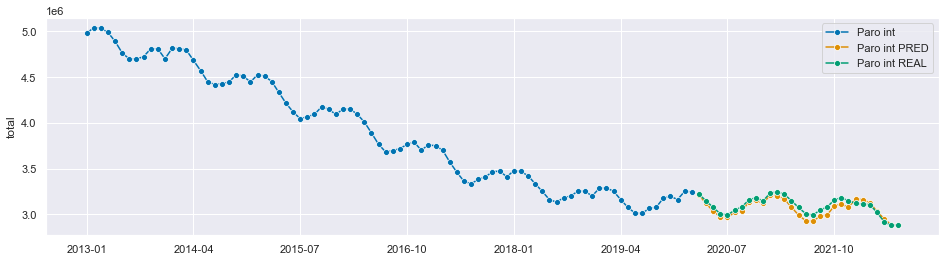

In [57]:
# representamos la serie predictiva
plot_series(y_train, paronew_pred_arima, y_test_arima,
            labels=["Paro int", "Paro int PRED", "Paro int REAL"])
plt.show()

In [59]:
mse = MeanSquaredError(square_root=True)
mse_arima = mse(y_test_arima,paronew_pred_arima)
print('El modelo ARIMA genera un RMSE de:', round(mse_arima,2))

El modelo ARIMA genera un RMSE de: 48459.23


In [60]:
mape = MeanAbsolutePercentageError(symmetric=False)
mape_arima = mape(y_test_arima,paronew_pred_arima)
print('El modelo ARIMA genera un MAPE de: {}%'.format(round(mape_arima*100,2)))

El modelo ARIMA genera un MAPE de: 1.36%


### Comparativa gráfica entre los modelos ETS y ARIMA

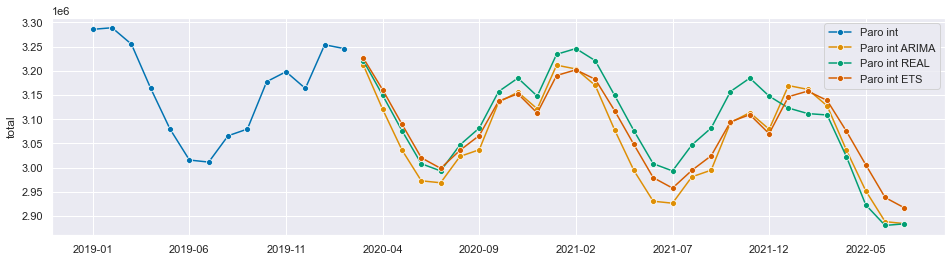

In [61]:
plot_series(y_train["2019":],paronew_pred_arima,y_test_arima,paronew_pred,
            labels=['Paro int','Paro int ARIMA','Paro int REAL','Paro int ETS'])
plt.show();
# plt.savefig('../pics/df_paro_new/etsarima.png')

Se aprecia bastante bien que ambos modelos se ajustan mucho más a estos datos intervenidos.

In [62]:
print('El modelo ETS genera un RMSE de:', round(mse_ets,2))
print('El modelo ARIMA genera un RMSE de:', round(mse_arima,2))

El modelo ETS genera un RMSE de: 42413.41
El modelo ARIMA genera un RMSE de: 48459.23


In [63]:
print('El modelo ETS genera un MAPE de: {}%'.format(round(mape_ets*100,2)))
print('El modelo ARIMA genera un MAPE de {}%'.format(round(mape_arima*100,2)))

El modelo ETS genera un MAPE de: 1.19%
El modelo ARIMA genera un MAPE de 1.36%


Aquí el mejor modelo sigue siendo **ETS**, que da menos error. Ahora probamos con Prophet.

### 4.3) Prophet

FB Prophet es un modelo muy extendido para la predicción de series temporales desarrollado por Facebook. El objetivo de este paquete es dar a los usuarios una herramienta potente y de fácil uso para predecir resultados de distintas series temporales. Este modelo alcanza sus mejores resultados con series estacionarias o series con una tendencia y estacionalidad marcadas, como es el caso del turismo en España. Suele ser peor cuando aumenta la aleatoria de la muestra. 

Dentro de nuestro DataFrame cambiamos el nombre de la columna temporal *'Periodo'* y la de la variable objetivo *'Total'* por *'ds'* e *'y'*, y también quitamos el Periodo como índice, pues todos estos cambios son necesarios para que el modelo funcione bien.

In [64]:
prophet_train = df_paro_new.reset_index() #cambiamos de índice
prophet_train.columns = ['ds', 'y'] #renombramos las columnas

In [65]:
prophet_y_train = y_train.copy()
prophet_y_train = prophet_y_train.rename_axis('index').reset_index()
prophet_y_train.columns = ['ds', 'y']
prophet_y_train['ds'] = prophet_y_train['ds'].dt.to_timestamp(freq = 'M')
len(prophet_y_train)

86

In [66]:
prophet_y_test = y_test.copy()
prophet_y_test = prophet_y_test.rename_axis('index').reset_index()
prophet_y_test.columns = ['ds', 'y']
prophet_y_test['ds'] = prophet_y_test['ds'].dt.to_timestamp(freq = 'M')
len(prophet_y_test)

21

In [67]:
prophet_y_train.tail()

,ds,y
81,2019-10-31,3177659.0
82,2019-11-30,3198184.0
83,2019-12-31,3163605.0
84,2020-01-31,3253853.0
85,2020-02-29,3246047.0


In [68]:
prophet_y_test.head()

,ds,y
0,2018-06-30,3162162.0
1,2018-07-31,3135021.0
2,2018-08-31,3182068.0
3,2018-09-30,3202509.0
4,2018-10-31,3254703.0


In [69]:
m = Prophet()
m.fit(prophet_y_train)

13:24:21 - cmdstanpy - INFO - Chain [1] start processing
13:24:21 - cmdstanpy - INFO - Chain [1] done processing


In [70]:
m_pred = m.make_future_dataframe(periods=len(prophet_y_test), freq='M')
prophet_forecast = m.predict(m_pred)

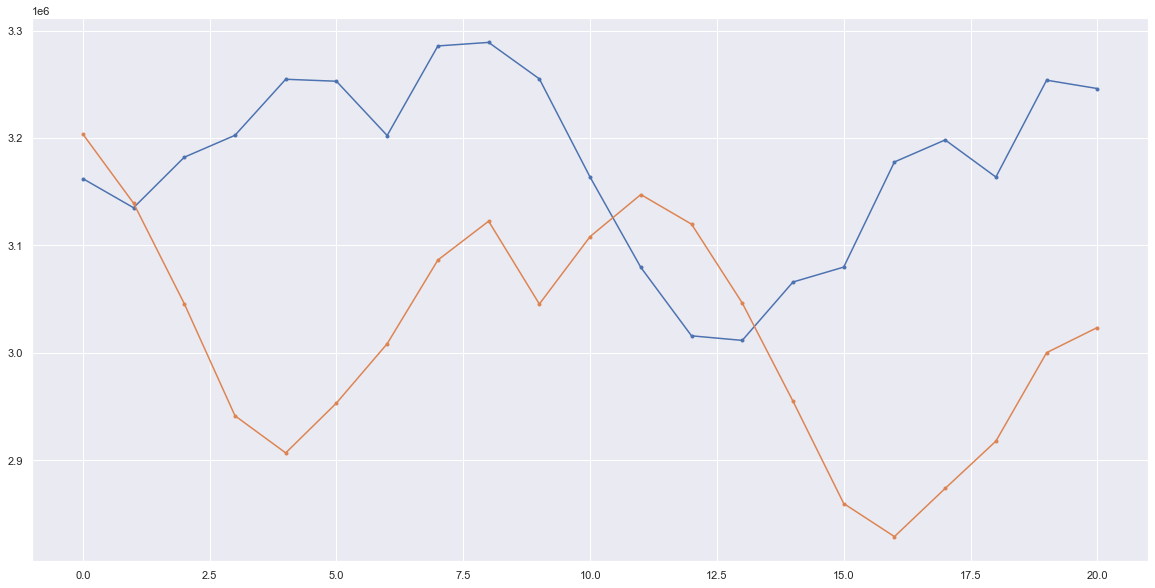

In [71]:
plt.plot(list(prophet_y_test['y']), '.-')
plt.plot(list(prophet_forecast.loc[86:, 'yhat']), '.-', label='Predicition')
plt.show()
# plt.savefig('../pics/df_paro_new/prophet.png')

In [72]:
# Forecast Accuracy
# MAPE
# mape_prophet = mean_absolute_percentage_error(prophet_y_test['y'], prophet_forecast.loc[47:, 'yhat'])
# mape_prophet

mape = MeanAbsolutePercentageError(symmetric=False)
mape_prophet = mape(prophet_y_test['y'], prophet_forecast.loc[86:, 'yhat'])
print('El modelo Prophet genera un MAPE de: {}%'.format(round(mape_prophet*100,2)))

El modelo Prophet genera un MAPE de: 5.73%


In [73]:
# Forecast Accuracy
#Mean Squared Error
mse = MeanSquaredError(square_root=True)
mse_prophet = mse(prophet_y_test['y'],prophet_forecast.loc[86:, 'yhat'])
print('El modelo Prophet genera un RMSE de:', round(mse_prophet,2))

El modelo Prophet genera un RMSE de: 210568.74


In [74]:
prophet_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].round().tail()

,ds,yhat,yhat_lower,yhat_upper
102,2021-07-31,2828648.0,2757703.0,2898855.0
103,2021-08-31,2873528.0,2798895.0,2952031.0
104,2021-09-30,2917569.0,2834194.0,3001657.0
105,2021-10-31,3000003.0,2913015.0,3087388.0
106,2021-11-30,3023421.0,2928316.0,3117272.0


### 4.4) Comparativa errores y elección del mejor modelo

Ahora comparamos entre las métricas de error que tenemos:
1) RMSE (Error dependiente de la escala)

In [78]:
print('El modelo ETS genera un RMSE de:', round(mse_ets,2))
print('El modelo ARIMA genera un RMSE de:', round(mse_arima,2))
print('El modelo Prophet genera un RMSE de:', round(mse_prophet,2))

El modelo ETS genera un RMSE de: 42413.41
El modelo ARIMA genera un RMSE de: 48459.23
El modelo Prophet genera un RMSE de: 210568.74


2) MAPE (Error porcentual)

In [77]:
print('El modelo ETS genera un MAPE de: {}%'.format(round(mape_ets*100,2)))
print('El modelo ARIMA genera un MAPE de {}%'.format(round(mape_arima*100,2)))
print('El modelo Prophet genera un MAPE de {}%'.format(round(mape_prophet*100,2)))

El modelo ETS genera un MAPE de: 1.19%
El modelo ARIMA genera un MAPE de 1.36%
El modelo Prophet genera un MAPE de 5.73%


Confirmamos que **el mejor modelo para la predicción de esta serie temporal es la ETS**, ya que es el que mejor se ajusta a los datos reales y es el que menor error da.

## *5) Predicción hasta finales de año*

A continuación realizamos la predicción de la serie temporal del desempleo intervenido hasta finales de año, es decir, hasta diciembre del 2022. 

In [79]:
# Especifico la cantidad de períodos a estimar para obtener las observaciones predichas en test.
fh = np.arange(1, 6)

# Selecciono el modelo y sus parámetros de predicción, al igual que los recursos a utilizar para entrenar
autoets_predict = AutoETS(auto=True, sp=12, n_jobs=-1)
y = df_paro_new.astype('float64').to_period('M')
autoets_predict.fit(y)

AutoETS(auto=True, n_jobs=-1, sp=12)

In [80]:
print(autoets_predict.summary())

                                 ETS Results                                  
Dep. Variable:                  total   No. Observations:                  115
Model:                       ETS(MAM)   Log Likelihood               -1313.822
Date:                Wed, 31 Aug 2022   AIC                           2663.644
Time:                        13:24:59   BIC                           2713.053
Sample:                    01-31-2013   HQIC                          2683.699
                         - 07-31-2022   Scale                            0.000
Covariance Type:               approx                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.9999      0.086     11.575      0.000       0.831       1.169
smoothing_trend         0.1541      0.069      2.237      0.025       0.019       0.289
smoothing_season

In [81]:
# Predicción del desempleo para los próximos 6 meses:
paronew_pred = autoets_predict.predict(fh=list(fh))
paronew_pred.round()

2022-08    2920012.0
2022-09    2947077.0
2022-10    3012890.0
2022-11    3026518.0
2022-12    2985489.0
Freq: M, dtype: float64

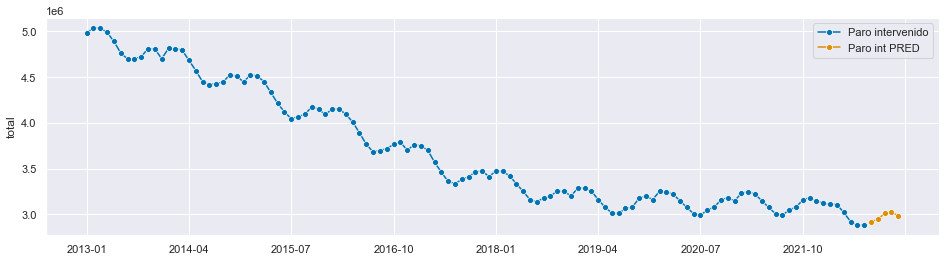

In [82]:
# Representamos gráficamente:
plot_series(y, paronew_pred, labels=["Paro intervenido", "Paro int PRED"])
plt.show()
# plt.savefig('../pics/df_paro_new/predict2022.png')